In [1]:
%matplotlib inline
import numpy as np
from numpy.random import normal, randint
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad, simps
import sys, os, gc
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

# Inputs

In [2]:
# Number of potentials:
n_V = int(1e5)
# x limits:
x_i = -1
x_f = 1
# Number of x coordinates for spline:
n_x = 100
x_vec = np.linspace(x_i, x_f, n_x)
# Number of x coordinates for potential generation
n_xpot = 10
xpot_vec = np.linspace(x_i,x_f,n_xpot)
# Damping factor
lamb = 0.8
# Potential standard deviation
sigma = 30/(x_f-x_i)**2
# Number of basis wavefunctions
n_basis = 20
basis_vec = np.arange(1,n_basis+1)
# Number of eigenvalues to train the neural network to predict
n_eig = 10

print("Input parameters:\n"
      "  n_V= %i\n"
      "  x_i= %0.2f\n"
      "  x_f= %0.2f\n"
      "  n_x= %i\n"
      "  n_xpot= %i\n"
      "  lamb= %0.2f\n"
      "  sigma= %0.2f\n"
      "  n_basis= %i\n"
      "  n_eig= %i\n"
      % (n_V,x_i, x_f, n_x, n_xpot, lamb, sigma, n_basis, n_eig))

Input parameters:
  n_V= 100000
  x_i= -1.00
  x_f= 1.00
  n_x= 100
  n_xpot= 10
  lamb= 0.80
  sigma= 7.50
  n_basis= 20
  n_eig= 10



# Generate the potentials

In [3]:
# Randomly select the value of the potential at the selected points
V_xpot = normal(loc=0, scale=sigma, size=(n_V,n_xpot))

# Form a cubic spline for each potential
V_interp = interp1d(xpot_vec, V_xpot, kind="cubic", axis=1)

# Evaluate the cubic spline at the grid
V_grid = V_interp(x_vec)

# Calculate the average of each potential
V_avg = simps(x=x_vec, y=V_grid)/2

# Remove the average
V_grid = V_grid# - np.outer(V_avg, np.ones(n_x))

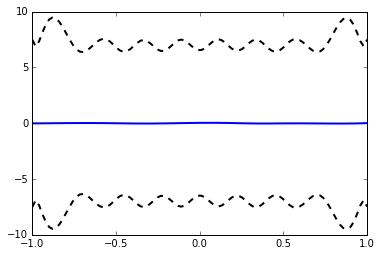

In [4]:
plt.clf()
plt.plot(x_vec, np.mean(V_grid, axis=0), 'b-', lw=2)
plt.plot(x_vec, np.mean(V_grid, axis=0)+np.std(V_grid, axis=0), 'k--', lw=2)
plt.plot(x_vec, np.mean(V_grid, axis=0)-np.std(V_grid, axis=0), 'k--', lw=2)

# Plot some random potentials

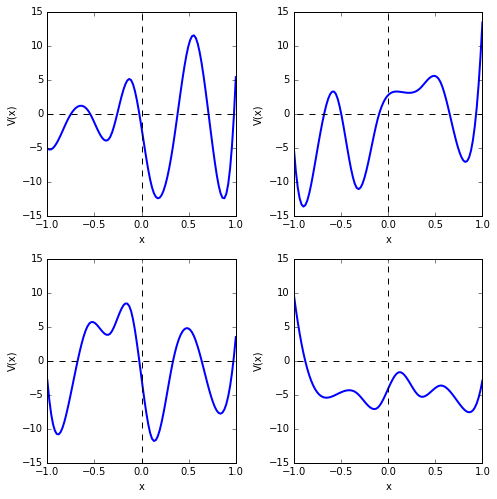

In [5]:
nrows = 2
ncols = 2
nplot = nrows * ncols
Vints = randint(0,n_V, nplot)
Vplot = V_grid[Vints,::]

plt.clf()
fig, axes = plt.subplots(nrows = nrows, ncols = ncols)
fig.set_size_inches(7,7)
subax = axes.flat

for i in range(0,nplot):
        subax[i].plot(x_vec, Vplot[i], linewidth = 2)
        subax[i].axhline(y=0,xmin=-1,xmax=1, linestyle='dashed' ,color = 'k')
        subax[i].axvline(x=0,ymin=-10,ymax=10, linestyle='dashed' ,color = 'k')
        subax[i].set_xlabel("x")
        subax[i].set_ylabel("V(x)")
        subax[i].set_ylim((-2*sigma,2*sigma))

plt.tight_layout()
plt.show()
plt.close()

# Calculate potential matrix elements

In [6]:
def psi0(n,x):
    '''
    n -- state index: starts from 1
    x -- position
    '''
    return np.sin(np.pi/2*np.outer(n,x+1))
def matel_integrand(n,m,x):
    return psi0(n+1,x) * psi0(m+1,x) * V_interp(x)
def matel(n,m):
    return simps(x=x_vec, y=matel_integrand(n,m,x_vec), axis=1)

In [7]:
Vmn=np.zeros((n_V,n_basis,n_basis))
for n in range(0,n_basis):
    for m in range(0,n_basis):
        Vmn[:,n,m] =matel(n,m)
        percent = (n*n_basis + m+1)/n_basis**2*100
        print("\rStatus: %0.2f %% complete" % percent, end='')

Status: 100.00 % complete

# Visualize the potential matrix elements

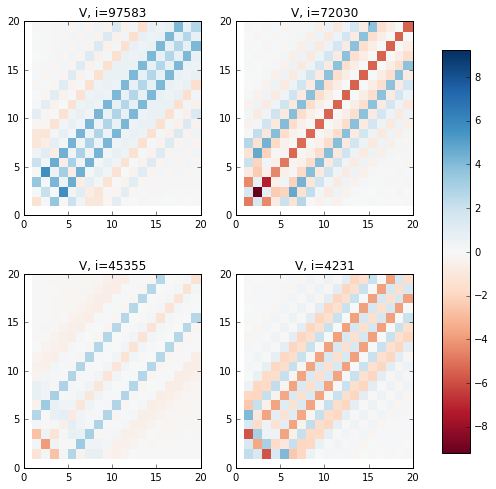

In [8]:
nrows = 2
ncols = 2
nplot = nrows * ncols
Vints = randint(0,n_V, nplot)
Vplot = Vmn[Vints]
z_min, z_max = -np.abs(Vplot).max(), np.abs(Vplot).max()

X,Y= np.meshgrid(basis_vec,basis_vec)

plt.clf()
fig, axes = plt.subplots(nrows = nrows, ncols = ncols)
fig.subplots_adjust(hspace=0.3)
fig.set_size_inches(4*ncols,4*nrows)
subax = axes.flat

for i in range(0,nplot):
        im = subax[i].pcolor(X,Y, Vplot[i], cmap = 'RdBu', vmin = z_min, vmax = z_max)
        subax[i].set_title("V, i="+str(Vints[i]))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
        
#plt.tight_layout()
plt.show()
plt.close()

# Construct the Hamiltonian matrices

In [9]:
def E0(n):
    return n**2 * np.pi**2 / 8.

E0ns = E0(basis_vec)

Hmn = np.diag(E0ns) + Vmn

In [10]:
np.diag(E0ns).shape

(20, 20)

In [11]:
Vmn.shape

(100000, 20, 20)

# Solve the eigensystem

In [12]:
import time
t1=time.time()
eigvals, eigvecs = np.linalg.eigh(Hmn)
print("Eigenvalues shape:", eigvals.shape)
print(time.time()-t1)
print("Eigenvectors shape:", eigvecs.shape)

Eigenvalues shape: (100000, 20)
7.482261896133423
Eigenvectors shape: (100000, 20, 20)


# Visualize the solutions

In [13]:
# Calculate the probability distribution
psiComp = psi0(basis_vec,x_vec)
print("psiComp.shape:", psiComp.shape)
psi=np.dot(eigvecs.transpose((0,2,1)),psiComp)
prob = psi**2
print("Size of data: %0.5f MB" % (sys.getsizeof(prob)/1e6))

psiComp.shape: (20, 100)
Size of data: 1600.00013 MB


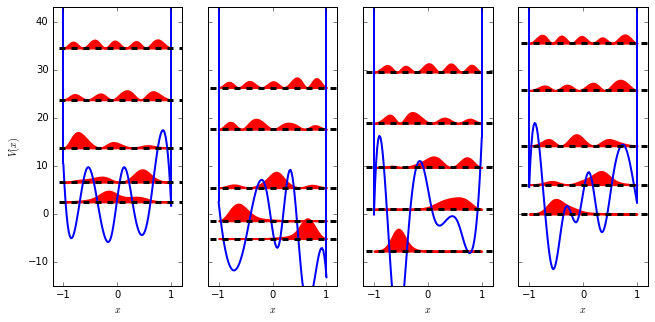

In [14]:
# Plot some random probability distributions
nrows = 1
ncols = 4
nplot = nrows * ncols
i_plt = randint(0,n_V, nplot)
numeigs = 5

V_grid_plt = V_grid[i_plt]
eigvals_plt = eigvals[i_plt]
prob_plt = prob[i_plt]

plt.clf()
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharey='all', sharex='all')
fig.set_size_inches(8+8./3.,5)
subax = axes.flat

for i in range(nplot):
    subax[i].plot(x_vec, V_grid[i_plt[i]], linewidth = 2)
    for j in range(numeigs):
        subax[i].fill_between(x_vec, eigvals_plt[i,j], eigvals_plt[i,j]+1.5*prob_plt[i,j], lw=2, color='r')
        subax[i].get_xaxis().set_ticks([-1,0,1])
        subax[i].axhline(y=eigvals_plt[i,j], xmin = -1, xmax = 1, 
                         ls = 'dashed', color = 'k', lw =3)
        subax[i].vlines(x=-1, ymin = V_grid[i_plt[i],0], ymax = 3*E0(numeigs), lw=2, color='b')
        subax[i].vlines(x=1, ymin = V_grid[i_plt[i],-1], ymax = 3*E0(numeigs), lw=2, color='b')
    if i >= (nrows-1)*ncols:
        subax[i].set_xlabel("$x$")
    if i is 0 or i is ncols:
        subax[i].set_ylabel("$V(x)$")
    subax[i].set_ylim((-2*sigma,1.4*E0(numeigs)))
    subax[i].set_xlim(1.2*x_i,1.2*x_f)

#plt.tight_layout()
plt.show()
plt.close()

# Scaled eigenvalues

In [15]:
eig_mu = np.mean(eigvals, axis = 0)
eig_std = np.std(eigvals, axis = 0)
eig_scaled = (eigvals - eig_mu) / eig_std

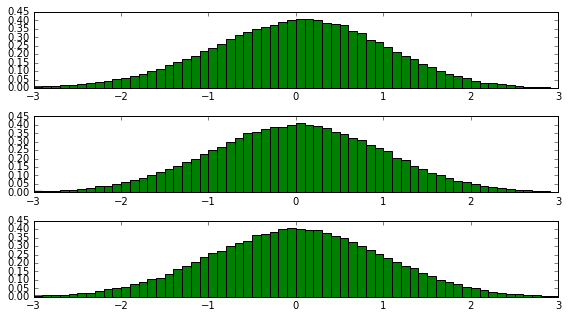

In [16]:
nrows = 3
ncols = 1
nplots = nrows*ncols
plt.clf()
fig, axes = plt.subplots(nrows, ncols)
fig.set_size_inches(8*ncols,1.5*nrows)
subax = axes.flat

nbins = 60
for i in range(0, nrows):
    subax[i].hist(eig_scaled[::,i], nbins, normed = 1, facecolor = 'green', 
                  alpha = 1, range = [-3,3])

plt.tight_layout()
plt.show()
plt.close()

# Neural Network

In [17]:
# Double the dataset using reflection symmetry
V_grid_flipped = V_grid[:,::-1]

# Quick and dirty test:
print(V_grid[2,0:3])
print(V_grid_flipped[2,-3:])

X = np.concatenate( (V_grid, V_grid_flipped) )
y = np.concatenate( (eig_scaled, eig_scaled) )[::,0:n_eig]

[ 8.01366162  7.24890351  6.42697854]
[ 6.42697854  7.24890351  8.01366162]


In [18]:
# Split test and train
test_frac = 0.3
random_state = 6
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_frac, random_state=random_state
)
print("X shape, y shape: ", X.shape, y.shape)
print("X_train shape, y_train shape: ", X_train.shape, y_train.shape)
print("X_test shape, y_test shape: ", X_test.shape, y_test.shape)

X shape, y shape:  (200000, 100) (200000, 10)
X_train shape, y_train shape:  (140000, 100) (140000, 10)
X_test shape, y_test shape:  (60000, 100) (60000, 10)


In [19]:
hidden_layers = (100,100)
model =MLPRegressor(hidden_layer_sizes=hidden_layers,
                    activation = 'tanh',
                    algorithm = 'adam',
                    alpha = 0.001,
                    beta_1 = 0.85,
                    beta_2 = 0.9,
                    batch_size = 'auto',
                    max_iter = 500,
                    tol = 1e-8,
                    learning_rate_init = 0.0001,
                    verbose = True
                 )

In [20]:
# Train the network
model.fit(X_train,y_train)

Iteration 1, loss = 0.13353104
Iteration 2, loss = 0.06491459
Iteration 3, loss = 0.04523105
Iteration 4, loss = 0.02959635
Iteration 5, loss = 0.02030843
Iteration 6, loss = 0.01463684
Iteration 7, loss = 0.01070997
Iteration 8, loss = 0.00792298
Iteration 9, loss = 0.00611526
Iteration 10, loss = 0.00492482
Iteration 11, loss = 0.00412834
Iteration 12, loss = 0.00358866
Iteration 13, loss = 0.00322030
Iteration 14, loss = 0.00294026
Iteration 15, loss = 0.00275274
Iteration 16, loss = 0.00260146
Iteration 17, loss = 0.00249061
Iteration 18, loss = 0.00237880
Iteration 19, loss = 0.00228896
Iteration 20, loss = 0.00223226
Iteration 21, loss = 0.00216603
Iteration 22, loss = 0.00210090
Iteration 23, loss = 0.00205642
Iteration 24, loss = 0.00202327
Iteration 25, loss = 0.00197857
Iteration 26, loss = 0.00194923
Iteration 27, loss = 0.00190899
Iteration 28, loss = 0.00187877
Iteration 29, loss = 0.00185329
Iteration 30, loss = 0.00182680
Iteration 31, loss = 0.00180197
Iteration 32, los

MLPRegressor(activation='tanh', algorithm='adam', alpha=0.001,
       batch_size='auto', beta_1=0.85, beta_2=0.9, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(100, 100),
       learning_rate='constant', learning_rate_init=0.0001, max_iter=500,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, tol=1e-08, validation_fraction=0.1,
       verbose=True, warm_start=False)

# Testing the NN

### Calculate errors on the training set as a reference point

In [21]:
# eigenvalue prediction
y_pred_train = model.predict(X_train)
err_train = np.sqrt(np.mean((y_pred_train - y_train)**2, axis=0))
print("Prediction error for each eigenvalue in the training set as ratio of std. dev.: \n", err_train)
print("Uniform average of prediction errors:\n %0.3f" % np.mean(err_train))

# Relative error
eig_pred_train = y_pred_train*eig_std[0:n_eig]+eig_mu[0:n_eig]
eig_train = y_train*eig_std[0:n_eig]+eig_mu[0:n_eig]
rel_err_train = np.mean(np.abs((eig_pred_train - eig_train)/eig_train), axis=0)
print("Prediction error for each eigenvalue in the training set as ratio of true value (rel. err.):\n", rel_err_train)

Prediction error for each eigenvalue in the training set as ratio of std. dev.: 
 [ 0.04500149  0.04731539  0.04290614  0.03211942  0.02904675  0.02479514
  0.01871034  0.01707215  0.01602649  0.01607324]
Uniform average of prediction errors:
 0.029
Prediction error for each eigenvalue in the training set as ratio of true value (rel. err.):
 [ 0.19838057  0.09862181  0.00928357  0.0032075   0.0017825   0.00104299
  0.00057715  0.00040942  0.00030125  0.00024756]


### Calculate errors on the test set

In [22]:
# eigenvalue prediction
y_pred_test = model.predict(X_test)
err_test = np.sqrt(np.mean((y_pred_test - y_test)**2, axis=0))
print("Prediction error for each eigenvalue in the testing set as ratio of std. dev.: \n", err_test)
print("Uniform average of prediction errors:\n %0.3f" % np.mean(err_test))

# Relative error
eig_pred_test = y_pred_test*eig_std[0:n_eig]+eig_mu[0:n_eig]
eig_test = y_test*eig_std[0:n_eig]+eig_mu[0:n_eig]
rel_err_test = np.mean(np.abs((eig_pred_test - eig_test)/eig_test), axis=0)
print("Prediction error for each eigenvalue in the testing set as ratio of true value (rel. err.):\n", rel_err_test)

Prediction error for each eigenvalue in the testing set as ratio of std. dev.: 
 [ 0.04579331  0.04843257  0.04414138  0.03258973  0.0294536   0.02481463
  0.01875819  0.01720542  0.01606158  0.01617524]
Uniform average of prediction errors:
 0.029
Prediction error for each eigenvalue in the testing set as ratio of true value (rel. err.):
 [ 0.17122075  0.1381382   0.00967067  0.0032104   0.0017963   0.00104642
  0.00057658  0.00040896  0.00030041  0.00024787]


## Visualize the predictions

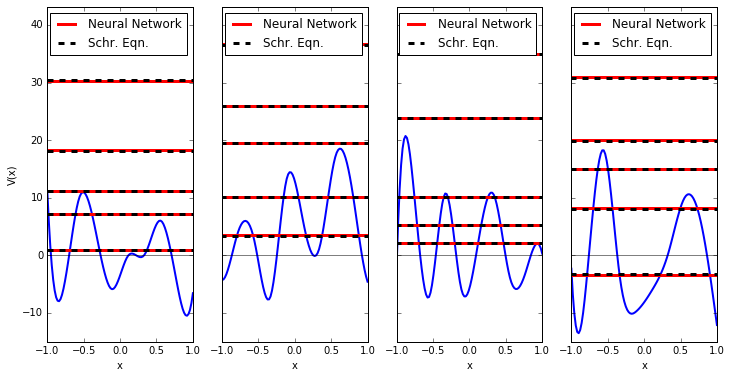

In [23]:
nrows = 1
ncols = 4
nplot = nrows * ncols
indplt = randint(0,X_test.shape[0], nplot)
numeigsplt = 5

plt.clf()
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharey=True)
fig.set_size_inches(12,6)
subax = axes.flat

for i in range(0, len(indplt)):
        subax[i].plot(x_vec, X_test[indplt[i]], linewidth = 2, label='$V(x)$')
        subax[i].axhline(y=0,xmin=-1,xmax=1, linestyle='solid' ,color = 'k', lw=0.5)
        for j in range(0, numeigsplt):
            lastaxNN = subax[i].axhline(y=eig_pred_test[indplt[i],j], xmin = -1, xmax = 1, 
                             ls = 'solid', color = 'r', lw = 3, label = 'Neural Network')
            lastaxSE = subax[i].axhline(y=eig_test[indplt[i],j], xmin = -1, xmax = 1, 
                             ls = 'dashed', color = 'k', lw =3, label = 'Schr. Eqn.')

        subax[i].set_xlabel("x")
        if i==0:
            subax[i].set_ylabel("V(x)")
        subax[i].set_ylim((-2*sigma, 1.4*E0(numeigsplt)))
        subax[i].legend([lastaxNN, lastaxSE], ["Neural Network", "Schr. Eqn."], fontsize=12)

# plt.tight_layout();
plt.show();
plt.draw()

## Test Cases

### Square well

In [24]:
V_square = np.asarray([np.zeros(n_x)])

# eigenvalue prediction
y_square_pred = model.predict(V_square)[0]
y_square_test = (E0ns[0:n_eig] - eig_mu[0:n_eig])/eig_std[0:n_eig]
err_square = np.sqrt((y_square_pred - y_square_test)**2)
print("Prediction error for each eigenvalue as ratio of std. dev.: \n", err_square)
print("Uniform average of prediction errors:\n %0.3f" % np.mean(err_square))

# Relative error
eig_square_pred = y_square_pred*eig_std[0:n_eig]+eig_mu[0:n_eig]
eig_square_test = y_square_test*eig_std[0:n_eig]+eig_mu[0:n_eig]
rel_err = np.abs((eig_square_pred - eig_square_test)/eig_square_test)
print("Prediction error for each eigenvalue as ratio of true value (rel. err.):\n", rel_err)

Prediction error for each eigenvalue as ratio of std. dev.: 
 [ 0.01281532  0.00512193  0.00463723  0.00872663  0.00252205  0.00611742
  0.00797149  0.0078901   0.0009765   0.00284957]
Uniform average of prediction errors:
 0.006
Prediction error for each eigenvalue as ratio of true value (rel. err.):
 [  3.43937563e-02   3.16572657e-03   1.25101668e-03   1.28971960e-03
   2.23547460e-04   3.62173734e-04   3.44702089e-04   2.59508412e-04
   2.52116285e-05   5.93194402e-05]


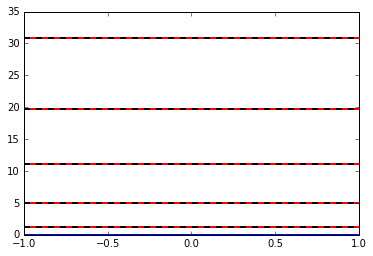

In [25]:
plt.clf()
plt.plot(x_vec, V_square[0], 'b-', lw=2)
for i in range(numeigs):
    plt.axhline(eig_square_pred[i], lw=2, ls='solid', color='r')
    plt.axhline(eig_square_test[i], lw=2, ls='dashed', color='k')

### Harmonic oscillator

In [26]:
# The harmonic oscillator potential with zero average value
def V_ho(A,x):
    return A*(x**2-1./3.)

# The energy levels
def E_ho(A,n):
    return -A/3. + (1 + 2*n)*np.sqrt(A/2)

In [34]:
A = 50
V_hos = [np.asarray(V_ho(A, x_vec))]
y_ho_pred = model.predict(V_hos)[0]
eig_ho_pred = y_ho_pred*eig_std[0:n_eig]+eig_mu[0:n_eig]

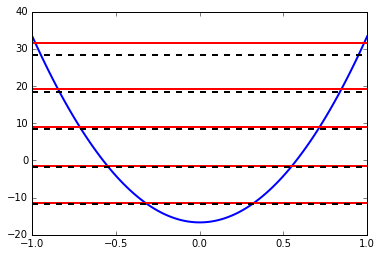

In [35]:
plt.clf()
plt.plot(x_vec, V_hos[0], 'b-', lw=2)
for i in range(numeigs):
    plt.axhline(eig_ho_pred[i], lw=2, ls='solid', color='r')
    plt.axhline(E_ho(A,i), lw=2, ls='dashed', color='k')

### Linear potential and symmetry test

In [36]:
# The harmonic oscillator potential with zero average value
A = 10
V_lin_p = [np.linspace(-A,A,n_x)]
V_lin_m = [np.linspace(A,-A,n_x)]

In [37]:
y_lin_p_pred = model.predict(V_lin_p)[0]
eig_lin_p_pred = y_lin_p_pred*eig_std[0:n_eig]+eig_mu[0:n_eig]

y_lin_m_pred = model.predict(V_lin_m)[0]
eig_lin_m_pred = y_lin_m_pred*eig_std[0:n_eig]+eig_mu[0:n_eig]

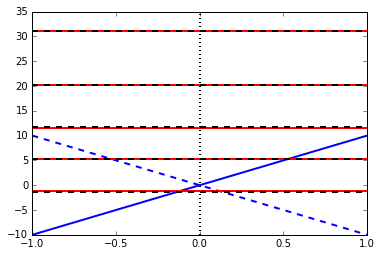

In [39]:
plt.clf()
plt.plot(x_vec, V_lin_p[0], 'b-', lw=2)
plt.plot(x_vec, V_lin_m[0], 'b--', lw=2)
plt.axvline(ls=':',lw=2,color='k')
for i in range(numeigs):
    plt.axhline(eig_lin_p_pred[i], lw=2, ls='solid', color='r')
    plt.axhline(eig_lin_m_pred[i], lw=2, ls='dashed', color='k')

### Shifted square well

In [54]:
shift = 5
V_square = shift + np.asarray([np.zeros(n_x)])


# eigenvalue prediction
y_square_pred = model.predict(V_square)[0]
y_square_test = (shift+E0ns[0:n_eig] - eig_mu[0:n_eig])/eig_std[0:n_eig]
err_square = np.sqrt((y_square_pred - y_square_test)**2)
print("Prediction error for each eigenvalue as ratio of std. dev.: \n", err_square)
print("Uniform average of prediction errors:\n %0.3f" % np.mean(err_square))

# Relative error
eig_square_pred = y_square_pred*eig_std[0:n_eig]+eig_mu[0:n_eig]
eig_square_test = y_square_test*eig_std[0:n_eig]+eig_mu[0:n_eig]
rel_err = np.abs((eig_square_pred - eig_square_test)/eig_square_test)
print("Prediction error for each eigenvalue as ratio of true value (rel. err.):\n", rel_err)

Prediction error for each eigenvalue as ratio of std. dev.: 
 [ 0.03439826  0.01541198  0.00738205  0.00992539  0.02826247  0.02069948
  0.0085855   0.01493865  0.00100939  0.0052593 ]
Uniform average of prediction errors:
 0.015
Prediction error for each eigenvalue as ratio of true value (rel. err.):
 [  1.82705046e-02   4.73161016e-03   1.37315181e-03   1.17041585e-03
   2.15564590e-03   1.10148222e-03   3.42892346e-04   4.62076421e-04
   2.48189158e-05   1.05218319e-04]


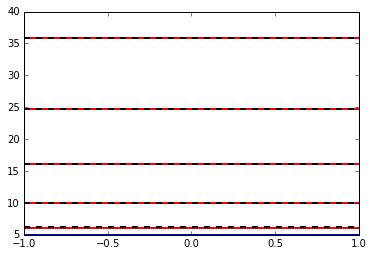

In [55]:
plt.clf()
plt.plot(x_vec, V_square[0], 'b-', lw=2)
for i in range(numeigs):
    plt.axhline(eig_square_pred[i], lw=2, ls='solid', color='r')
    plt.axhline(eig_square_test[i], lw=2, ls='dashed', color='k')